
# Leeway backtracking


In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import opendrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.leeway import Leeway
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

In [2]:
d03 = xr.open_dataset('C:/Users/bente/Documents/THESIS/OO-2023/OO-2023.nc')
d03 = d03.traj.gridtime('1H')
d03 = d03.isel(trajectory=0)

We try to find the likelihood of the origin of a found object by two different methods:
1. backwards simulation from position where object is found ('Observation')
2. forwards simulation from a uniform grid of possible initial locations, selecting the origins of particles actually hitting the observed target

We use 24 hours from the NorKyst ocean model (800m pixel size) and Arome atmospheric model (2.5km pixel size)



In [3]:
orev = Leeway(loglevel=50)
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})
orev.add_reader([reader_globcur, reader_wind])

duration = timedelta(hours=48)                # 2 days
start_time = datetime(2023,3,6,3,12,8)
end_time = start_time + duration

object_type = 26  # 26 = Life-raft, no ballast
outfile = 'D:/backtrack/agulhas_test14.nc'
try:
    os.remove(outfile)
except:
    print("No such file")
ilon = d03.lon.sel(time=slice(datetime(2023, 3, 8, 3, 12, 8), datetime(2023, 3, 8, 3, 12, 8))).values  # Incident position
ilat = d03.lat.sel(time=slice(datetime(2023, 3, 8, 3, 12, 8), datetime(2023, 3, 8, 3, 12, 8))).values
text = [{'s': 'Observation', 'x': ilon, 'y': ilat, 'fontsize': 20, 'color': 'g', 'zorder': 1000}]
# Define domain of possible origin
#lons = np.arange(3.4, 5, .1/20)
#lats = np.arange(59.7, 60.8, .05/20)
lons = np.arange(28.3, 29.4, .1/2) # Much coarser CCC
lats = np.arange(-37.2, -36.2, .05/2)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)

In [4]:
start_time

datetime.datetime(2023, 3, 6, 3, 12, 8)

In [6]:
d03.lon.sel(time=slice(datetime(2023, 3, 6, 3, 12, 8), datetime(2023, 3, 6, 3, 12, 8))).values

array([28.64248414])

In [152]:
path = 'D:/backtrack/'

Simulating first backwards for 24 hours:



10:14:35 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
10:14:35 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
10:14:35 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
10:14:35 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
10:14:35 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
10:14:35 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
10:14:35 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/agulhas_test14.nc
10:14:35 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
10:14:35 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
10:14:35 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=[28.3, 29.350000000000016, -37.2, -36.22500000000006], fast=True, lscale=None
10:14:35 WARNING opendrift.

<Figure size 640x480 with 0 Axes>

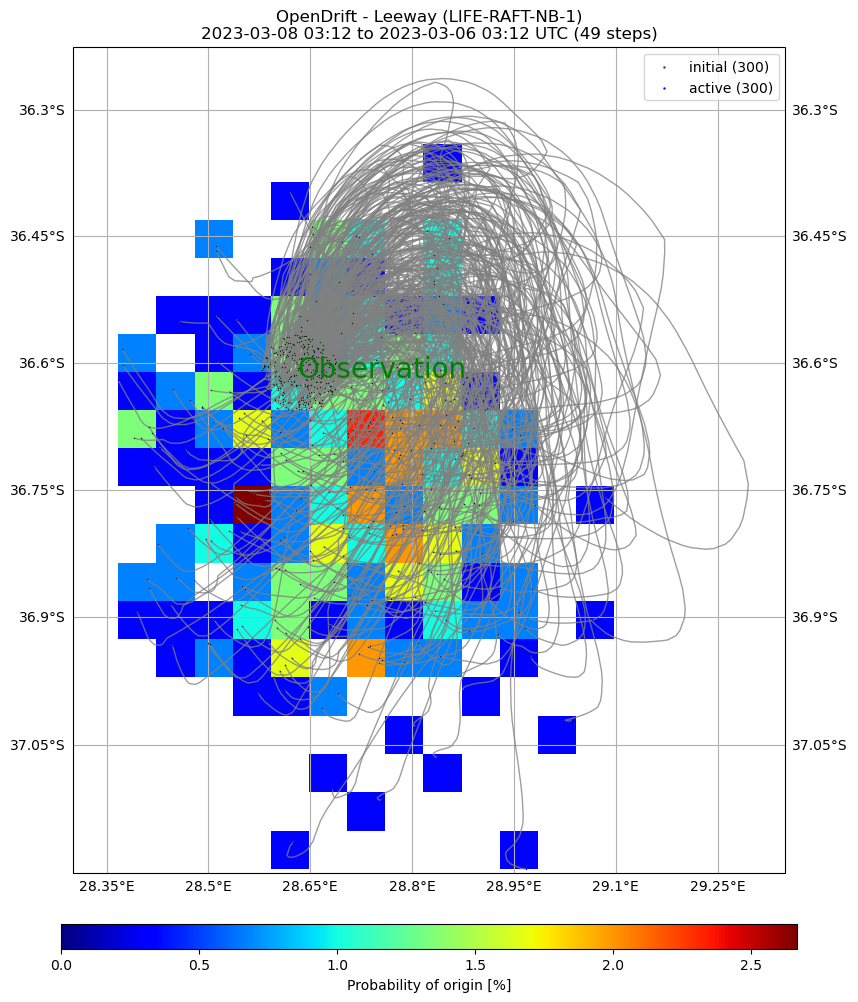

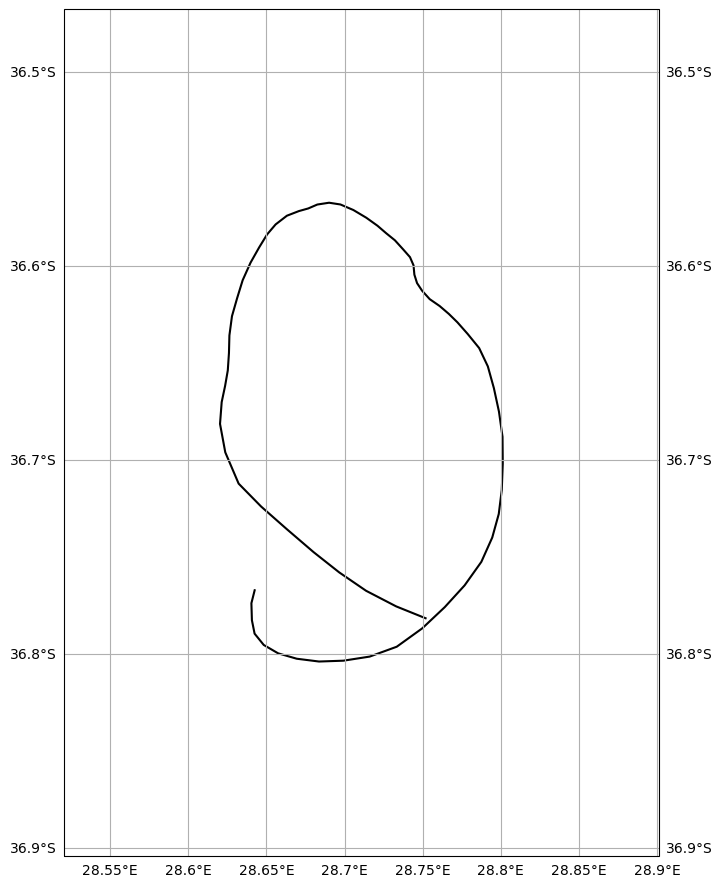

In [153]:
#o.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=30000,
#                 time=end_time, object_type=object_type)
orev.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=300,
                 time=end_time, object_type=object_type)
orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile)
od = opendrift.open_xarray(outfile)
density_backwards = od.get_histogram(pixelsize_m=5000).isel(time=-1).isel(origin_marker=0)
density_backwards = density_backwards.where(density_backwards>0)
density_backwards = density_backwards/density_backwards.sum()*100
vmax = density_backwards.max()

plt.figure()

orev.plot(background=density_backwards, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)
d03.sel(time=slice('2023-03-06', '2023-03-08')).traj.plot(color='black')
#os.remove(path+outfile)

Try to use the "initial" locations from the reverse drift as initial locations for a forward run. 



In [202]:
outfile = 'D:/backtrack/agulhas_test12_forward.nc'
try:
    os.remove(outfile)
except:
    print("No such file")

No such file


In [203]:
lonrev, latrev = orev.get_lonlats()
loninit = np.tile(lonrev[:,-1],(10,1))
latinit = np.tile(latrev[:,-1],(10,1))

# TODO: multiply these 300 to 30000 particles randomly scattered about each of the original points with given radius
orevfwd = Leeway(loglevel=50)
orevfwd.add_reader([reader_globcur, reader_wind])
orevfwd.seed_elements(lon=loninit, lat=latinit, radius=500.0, radius_type='gaussian', 
                 time=start_time, object_type=object_type)
orevfwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
#print(orevfwd)


11:06:35 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
11:06:35 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
11:06:35 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
11:06:35 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
11:06:35 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
11:06:35 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
11:06:35 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/agulhas_test12_forward.nc
11:06:35 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
11:06:35 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
11:06:35 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
11:06:35 DEBUG   opendrift.export.io_netcdf:365: Setting import

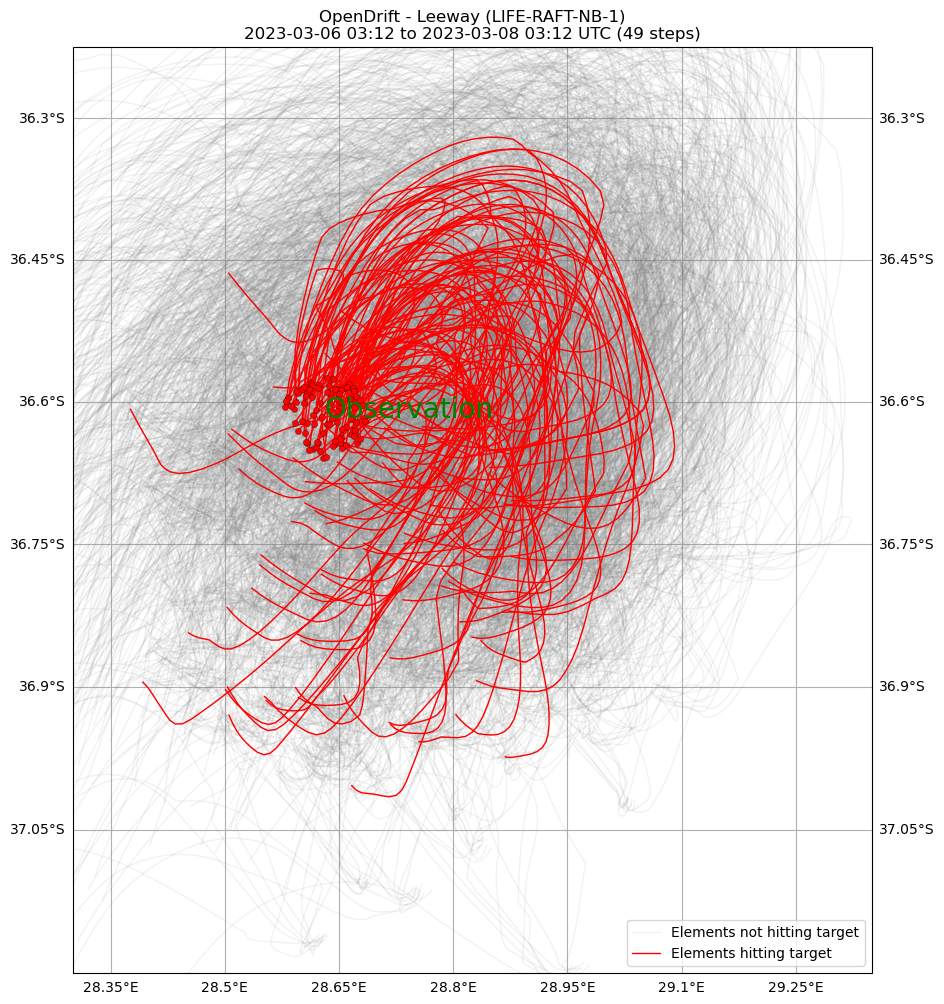

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-06 03:12 to 2023-03-08 03:12 UTC (49 steps)'}>,
 <Figure size 949.641x1100 with 1 Axes>)

In [204]:
lon, lat = orevfwd.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

#orevfwd.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, corners=corners, text=text)
orevfwd.plot(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], show_elements=False, fast=True, corners=corners, text=text)

In [217]:
ax.plot(density_revfwd/density_revfwd.sum()*100)

In [219]:
density_revfwd.lon_bin

<xarray.DataArray 'lon_bin' (lon_bin: 29)>
array([27.747407, 27.803684, 27.859961, 27.916238, 27.972515, 28.028792,
       28.085069, 28.141346, 28.197623, 28.2539  , 28.310177, 28.366454,
       28.422731, 28.479008, 28.535285, 28.591562, 28.647839, 28.704116,
       28.760393, 28.81667 , 28.872947, 28.929224, 28.985501, 29.041778,
       29.098055, 29.154332, 29.210609, 29.266886, 29.323163])
Coordinates:
    time           datetime64[ns] 2023-03-06T03:12:08
    origin_marker  int32 0
  * lon_bin        (lon_bin) float64 27.75 27.8 27.86 ... 29.21 29.27 29.32
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude
    minval:         27.775545
    maxval:         29.323357

11:06:48 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
11:06:48 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
11:06:48 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
11:06:48 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
11:06:48 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
11:06:48 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
11:06:48 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/agulhas_test12_forward.nc
11:06:48 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
11:06:48 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
11:06:48 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=[28.3, 29.350000000000016, -37.2, -36.22500000000006], fast=True, lscale=None
11:06:48 WARNING op

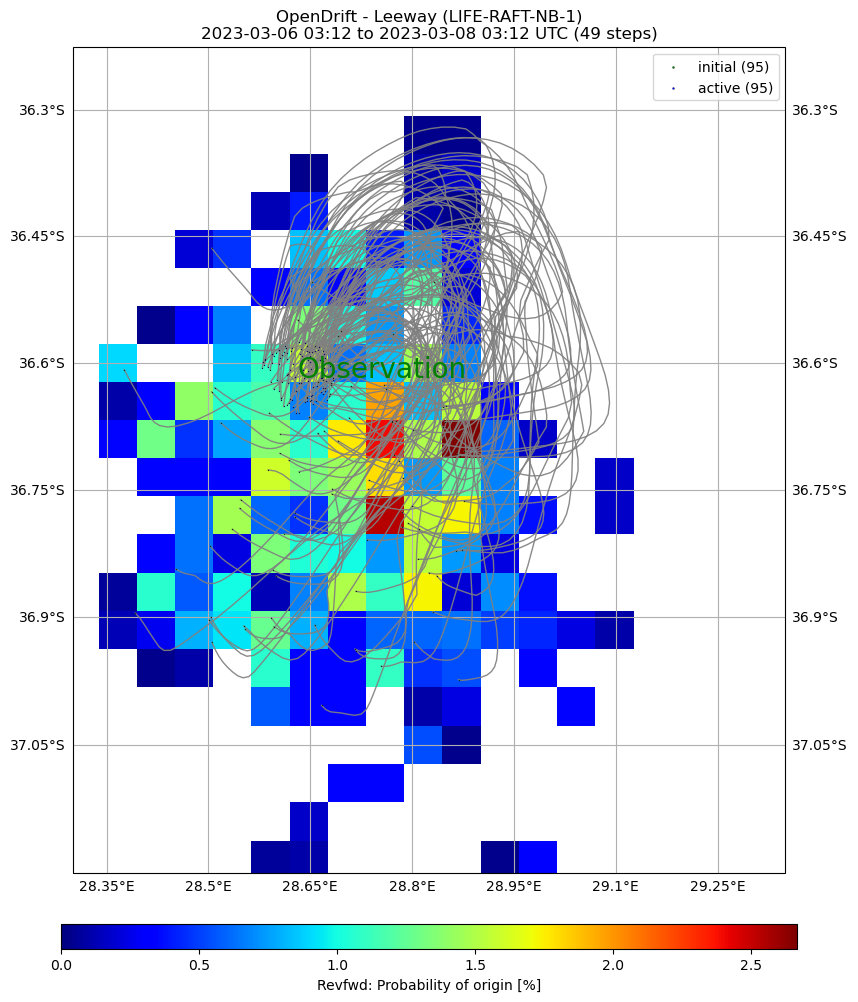

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-06 03:12 to 2023-03-08 03:12 UTC (49 steps)'}>,
 <Figure size 949.641x1100 with 2 Axes>)

In [205]:
orf = opendrift.open_xarray(outfile)#, elements=hits)             #!!!!!! THIS IS WEIRD !!!!!!

density_revfwd = orf.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_revfwd = density_revfwd.where(density_revfwd>0)
o_hit.plot(background=density_revfwd/density_revfwd.sum()*100, clabel='Revfwd: Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)

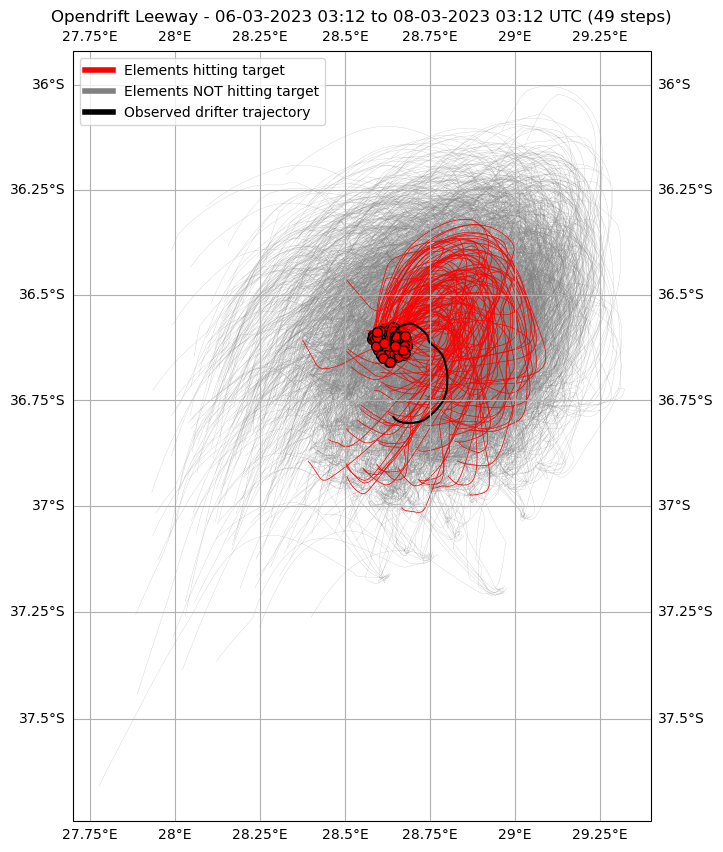

In [165]:
sim = xr.open_dataset(outfile)

hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]

plt.close()

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(0,2999):
    sim.isel(trajectory=i).traj.plot(linewidth=0.1)
    
for i in hits: 
    sim.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
    ax.plot(sim.isel(trajectory=i).isel(time=48).lon.values, sim.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-03-06 03:12:08', '2023-03-08 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Elements hitting target', 'Elements NOT hitting target', 'Observed drifter trajectory'])


plt.gca().autoscale()
plt.title('Opendrift Leeway - 06-03-2023 03:12 to 08-03-2023 03:12 UTC (49 steps)')
plt.show()

Simulating forward, starting at a uniform grid 24 hours earlier (440 x 320 = 140800 elements at ~500m separation)




In [166]:
outfile = 'D:/backtrack/agulhas_test8_forward_uniform.nc'

In [167]:
ofwd = Leeway(loglevel=50)
ofwd.add_reader([reader_globcur, reader_wind])
ofwd.seed_elements(lon=lons, lat=lats, radius=0,
                 time=start_time, object_type=object_type)
try:
    os.remove(outfile)
except:
    print("No such file")
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
#print(ofwd)

Finding the elements actually hitting the target (within 5 km) after 48 hours:

In [168]:
lon, lat = ofwd.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

#ofwd.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, corners=corners, text=text)

10:26:13 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
10:26:13 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
10:26:13 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
10:26:13 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
10:26:13 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
10:26:13 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
10:26:13 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/agulhas_test8_forward_uniform.nc
10:26:13 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
10:26:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
10:26:13 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
10:26:13 DEBUG   opendrift.export.io_netcdf:365: Setting

<img src="file://gallery/animations/example_leeway_backtrack_0.gif">



10:26:24 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=[28.3, 29.350000000000016, -37.2, -36.22500000000006], fast=True, lscale=None
10:26:24 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


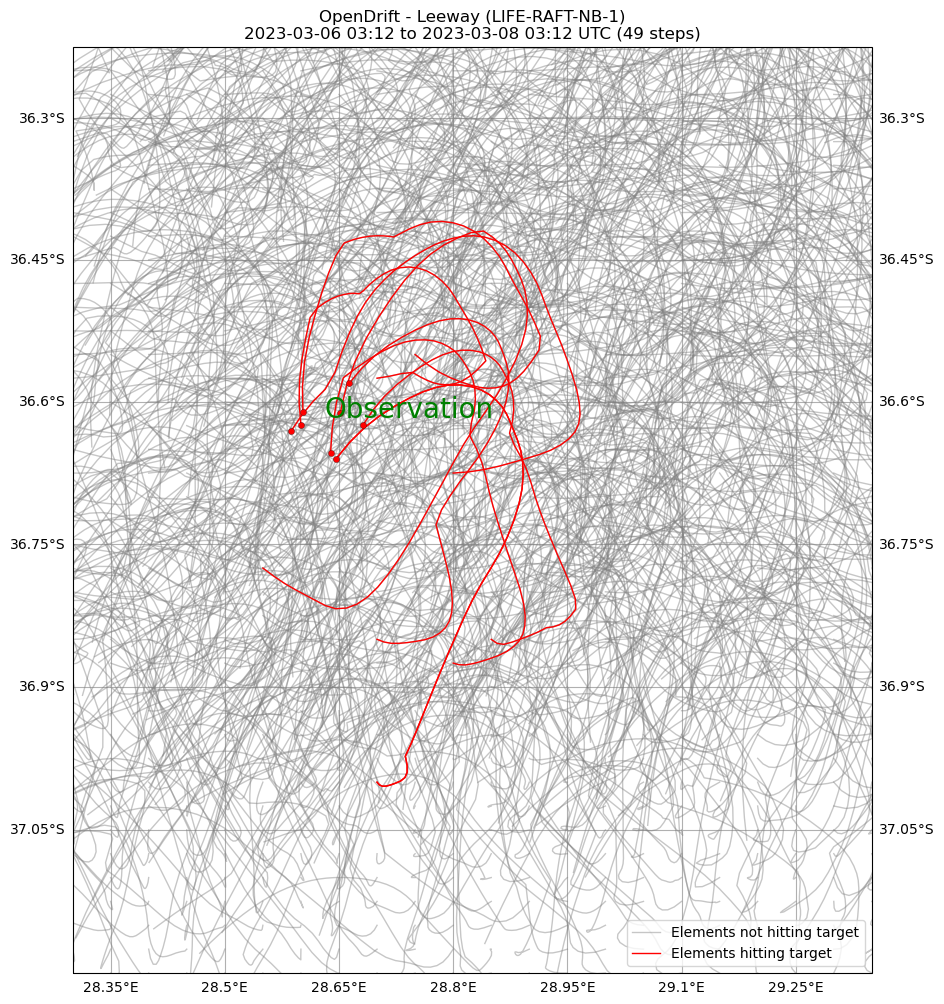

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-06 03:12 to 2023-03-08 03:12 UTC (49 steps)'}>,
 <Figure size 949.641x1100 with 1 Axes>)

In [169]:
ofwd.plot(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], show_elements=False, fast=True, corners=corners, text=text)

In [170]:
sim = xr.open_dataset(outfile)
sim

<xarray.Dataset>
Dimensions:               (trajectory: 880, time: 49)
Coordinates:
  * trajectory            (trajectory) int32 1 2 3 4 5 6 ... 876 877 878 879 880
  * time                  (time) datetime64[ns] 2023-03-06T03:12:08 ... 2023-...
Data variables: (12/22)
    status                (trajectory, time) int32 ...
    moving                (trajectory, time) int32 ...
    age_seconds           (trajectory, time) float32 ...
    origin_marker         (trajectory, time) int32 ...
    lon                   (trajectory, time) float32 ...
    lat                   (trajectory, time) float32 ...
    ...                    ...
    current_drift_factor  (trajectory, time) float32 ...
    x_wind                (trajectory, time) float32 ...
    y_wind                (trajectory, time) float32 ...
    x_sea_water_velocity  (trajectory, time) float32 ...
    y_sea_water_velocity  (trajectory, time) float32 ...
    land_binary_mask      (trajectory, time) float32 ...
Attributes: (12/64)
    Conventions:                                       CF-1.6
    standard_name_vocabulary:                          CF-1.6
    featureType:                                       trajectory
    history:                                           Created 2024-01-23 10:...
    source:                                            Output from simulation...
    model_url:                                         https://github.com/Ope...
    ...                                                ...
    geospatial_lat_resolution:                         point
    geospatial_lon_min:                                0.0
    geospatial_lon_max:                                0.0
    geospatial_lon_units:                              degrees_east
    geospatial_lon_resolution:                         point
    runtime:                                           0:00:03.677071

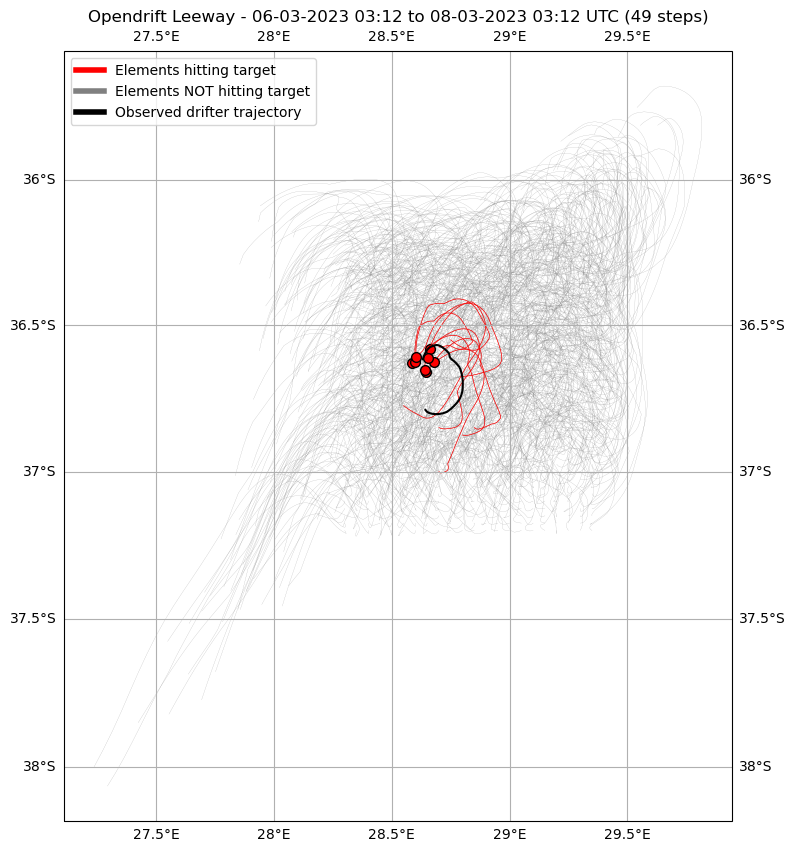

In [171]:
sim = xr.open_dataset(outfile)

hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]

plt.close()

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(0,879):
    sim.isel(trajectory=i).traj.plot(linewidth=0.1)
    
for i in hits: 
    sim.isel(trajectory=i).traj.plot(linewidth=0.5, color='red')
    ax.plot(sim.isel(trajectory=i).isel(time=48).lon.values, sim.isel(trajectory=i).isel(time=48).lat.values, 'ro', mec='black', markersize=7, transform=ccrs.Geodetic())

d03.sel(time=slice('2023-03-06 03:12:08', '2023-03-08 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Elements hitting target', 'Elements NOT hitting target', 'Observed drifter trajectory'])


plt.gca().autoscale()
plt.title('Opendrift Leeway - 06-03-2023 03:12 to 08-03-2023 03:12 UTC (49 steps)')
plt.show()

Plot the initial density of elements that actually hit the target after 24 hours. To be compared with the density figure from backwards simulation (see top)



In [182]:
of = opendrift.open_xarray(outfile)#, elements=hits)
#of = of(elements=hits)
density_forwards = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_forwards = density_forwards.where(density_forwards>0)
#o_hit.plot(background=density_forwards/density_forwards.sum()*100, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)

10:46:51 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
10:46:51 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
10:46:51 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
10:46:51 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
10:46:51 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
10:46:51 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
10:46:51 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/agulhas_test8_forward_uniform.nc
10:46:51 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
10:46:51 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...


In [189]:
xr.open_dataset(outfile).lon.values

array([[28.3     , 28.304657, 28.306177, ..., 27.314728, 27.275455,
        27.2356  ],
       [28.35    , 28.347382, 28.346678, ..., 27.766842, 27.72997 ,
        27.692568],
       [28.4     , 28.400799, 28.401022, ..., 27.803621, 27.766623,
        27.72877 ],
       ...,
       [29.25    , 29.264227, 29.278622, ..., 29.35537 , 29.35532 ,
        29.355036],
       [29.3     , 29.32766 , 29.355465, ..., 29.298399, 29.285978,
        29.272371],
       [29.35    , 29.358322, 29.3671  , ..., 29.75792 , 29.764973,
        29.771898]], dtype=float32)

In [181]:
density_forwards = sim.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_forwards = density_forwards.where(density_forwards>0)

AttributeError: 'Dataset' object has no attribute 'get_histogram'

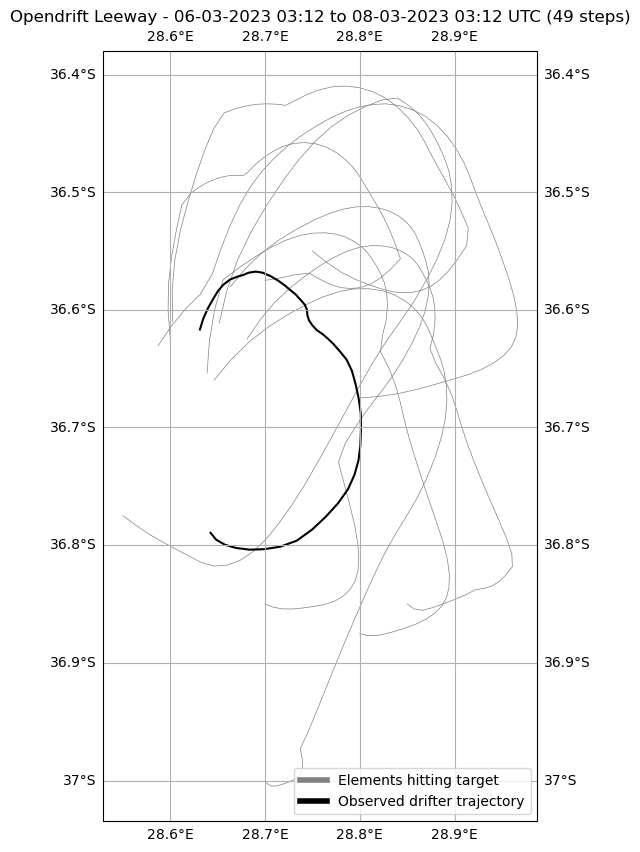

In [177]:
plt.close()

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)
    
ax.plot(background=density_forwards/density_forwards.sum()*100)

for i in hits: 
    sim.isel(trajectory=i).traj.plot(linewidth=0.5, color='grey')
    
d03.sel(time=slice('2023-03-06 03:12:08', '2023-03-08 03:12:08')).traj.plot(color='black')  

custom_lines = [Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Elements hitting target', 'Observed drifter trajectory'])


plt.gca().autoscale()
plt.title('Opendrift Leeway - 06-03-2023 03:12 to 08-03-2023 03:12 UTC (49 steps)')
plt.show()